# 10x.x. How to make a color image

<div>
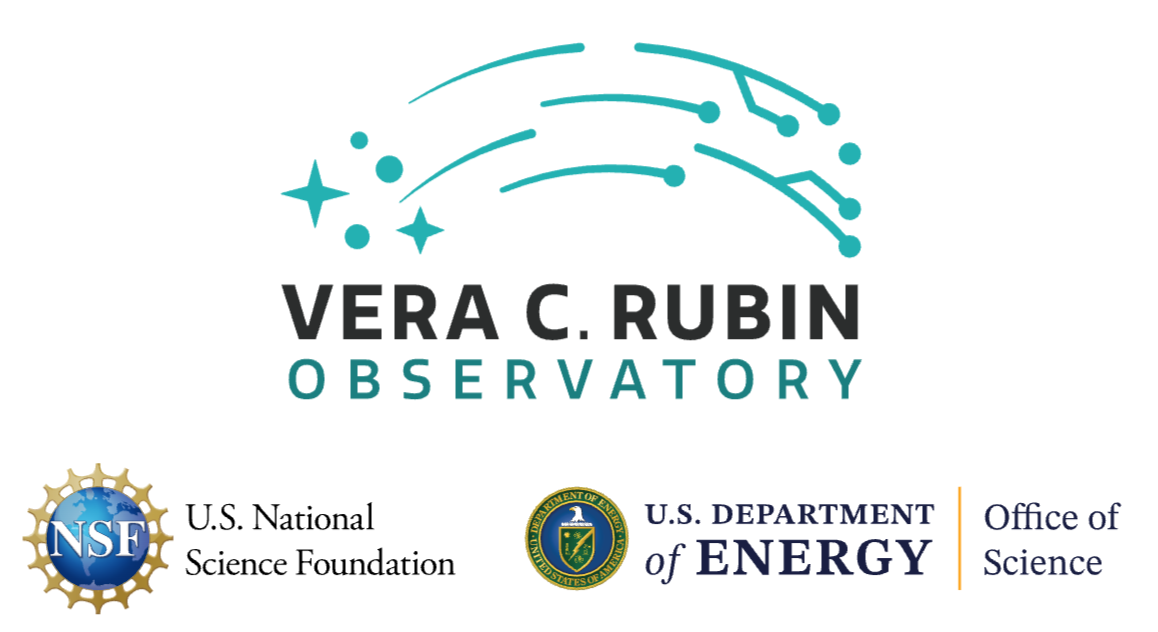
</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.1.1 <br>
Last verified to run: 2025-07-25 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** How to make a color image.

**LSST data products:** 

**Packages:** 

**Credit:** Originally developed by the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.


Nate, Céline, Phil, Robert, Clare


Section 1 based on notebook by Phil Marshall, Phil Holloway, Ralf Kaehler, Ferro Shao. 

Section 2 based on notebook by Céline Combet. 

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction



**Related tutorials: See the 100-level series on image display**

### 1.1. Import packages

Import the `Butler` and `Timespan` modules from the `lsst.daf.butler` package, and the `display` module from the `lsst.afw` package (for image display).
Also import the `Time` function from the `astropy.time` module. 

In [80]:
from lsst.daf.butler import Butler, Timespan
import lsst.afw.display as afwDisplay
from astropy.time import Time

import lsst.sphgeom as sphgeom

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler
import lsst.afw.display as afw_display
from lsst.afw.image import MultibandExposure
from astropy.visualization import make_lupton_rgb
from lsst.afw.geom import makeSkyWcs

import lsst.sphgeom as sphgeom
import lsst.geom as geom
from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_symbols,
                                 get_multiband_plot_linestyles)

import matplotlib.pyplot as plt

from lsst.pipe.tasks.prettyPictureMaker import PrettyPictureConfig, PrettyPictureTask
from lsst.pipe.tasks.prettyPictureMaker._task import ChannelRGBConfig

from lsst.ip.diffim import GetTemplateTask

from lsst.afw.image import Image
from lsst.afw.image import MultibandExposure
from lsst.afw.geom import makeSkyWcs
from astropy.visualization import make_lupton_rgb

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS

from photutils.aperture import SkyCircularAperture
from astropy import units as u
from astropy.coordinates import SkyCoord

import astropy.units as u
from astropy.coordinates import SkyCoord

### 1.2. Define parameters and functions

Set `afwDisplay` to use Firefly, and define `afw_display` to show images in frame 1.

In [53]:
def showRGB(image, bgr="gri", ax=None, fp=None,
            figsize=(8,8), stretch=100, Q=1, name=None):
    """Display an RGB color composite image with matplotlib.
    
    Parameters
    ----------
    image : `MultibandImage`
        `MultibandImage` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e. keys of the exps dict) indicating what band
        to use for each channel. If `image` only has three filters then this parameter is ignored
        and the filters in the image are used.
    ax : `matplotlib.axes.Axes`
        Axis in a `matplotlib.Figure` to display the image.
        If `axis` is `None` then a new figure is created.
    figsize: tuple
        Size of the `matplotlib.Figure` created.
        If `ax` is not `None` then this parameter is ignored.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    name: str
        The name of the object/field to be displayed.
    """
    if len(image) == 3:
        bgr = ''.join(image.bands)
    print (bgr)
    rgb = make_lupton_rgb(image_r=image[bgr[2]].array,
                          image_g=image[bgr[1]].array,
                          image_b=image[bgr[0]].array,
                          stretch=stretch, Q=Q)
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)
    
    plt.axis("off")
    ax.imshow(rgb, interpolation='nearest', origin='lower')

    if name is not None:
        plt.text(0, 31, name, color='white', fontsize=12,
                 horizontalalignment='left', verticalalignment='top')
    
    plt.text(0, 2, 'astropy Lupton '+bgr, color='white',
             fontsize=12, horizontalalignment='left', verticalalignment='top')
    
    plt.tight_layout();

    return

In [90]:
def prettyRGB(images, ax=None, fp=None, figsize=(8,8), stretch=250, Q=0.7, name=None):
    """Display an RGB (irg) color composite image with matplotlib using
    the prettyPictureMaker pipe task.
    
    Parameters
    ----------
    images : dict
        Dictionary of images to display.
    ax : `matplotlib.axes.Axes`
        Axis in a `matplotlib.Figure` to display the image.
        If `axis` is `None` then a new figure is created.
    figsize: tuple
        Size of the `matplotlib.Figure` created.
        If `ax` is not `None` then this parameter is ignored.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    name: str
        The name of the object/field to be displayed.
    """

    prettyPicConfig = PrettyPictureTask.ConfigClass()
    # Magic from Nate Lust:
    prettyPicConfig.localContrastConfig.doLocalContrast = False
    prettyPicConfig.localContrastConfig.sigma = 30
    prettyPicConfig.localContrastConfig.clarity = 0.8
    prettyPicConfig.localContrastConfig.shadows = 0
    prettyPicConfig.localContrastConfig.highlights = -1.5
    prettyPicConfig.localContrastConfig.maxLevel = 2
    prettyPicConfig.imageRemappingConfig.absMax = 11000
    prettyPicConfig.luminanceConfig.max = 100
    prettyPicConfig.luminanceConfig.stretch = stretch    # from kwargs
    prettyPicConfig.luminanceConfig.floor = 0
    prettyPicConfig.luminanceConfig.Q = Q                # from kwargs
    prettyPicConfig.luminanceConfig.highlight = 0.905882
    prettyPicConfig.luminanceConfig.shadow = 0.12
    prettyPicConfig.luminanceConfig.midtone = 0.25
    prettyPicConfig.doPSFDeconcovlve = False   # sic
    prettyPicConfig.exposureBrackets = None
    prettyPicConfig.colorConfig.maxChroma = 80
    prettyPicConfig.colorConfig.saturation = 0.6
    prettyPicConfig.cieWhitePoint = (0.28, 0.28)
    prettyPicConfig.channelConfig = dict(
        g=ChannelRGBConfig(r=0.0, g=0.0, b=1.0),
        r=ChannelRGBConfig(r=0.0, g=1.0, b=0.0),
        i=ChannelRGBConfig(r=1.0, g=0.0, b=0.0),
    )
    prettyPicTask = PrettyPictureTask(config=prettyPicConfig)
    
    bands = "gri"
    coaddG = images['g']
    coaddR = images['r']
    coaddI = images['i']
    
    prettyPicInputs = prettyPicTask.makeInputsFromExposures(i=coaddI, r=coaddR, g=coaddG)
    coaddRgbStruct = prettyPicTask.run(prettyPicInputs)
    coaddRgb = coaddRgbStruct.outputRGB

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)
    
    plt.axis("off")
    ax.imshow(coaddRgb, interpolation='nearest', origin='lower')

    if name is not None:
        plt.text(0, 0.4, name, color='white', fontsize=12,
                 horizontalalignment='left', verticalalignment='top')
    
    plt.text(0, 0.3, 'PrettyPictureTask '+bands, color='white', fontsize=12,
             horizontalalignment='left', verticalalignment='top')
    
    plt.tight_layout();

    return

In [91]:
afw_display.setDefaultBackend('matplotlib')

Create an instance of the butler, and assert that it exists.

In [92]:
butler = Butler("dp1", collections="LSSTComCam/DP1")
assert butler is not None

Define the approximate central coordinates of the EDFS target field, in degrees, and a region within 1 degree of this center.

# 1. Euclid lens cutout

Make a cutout of a strong lens candidate from Euclid data in the Euclid Deep Field south DP1 field. 

Define the approximate coordinates of the lens, in degrees, and a region within 0.2 degree of it.
Coordinates from (website, paper Euclid QR1). 

In [93]:
ra_cen_euclid = 59.626134
dec_cen_euclid = -49.06175

my_band = 'i'

Define the stamp size.

In [94]:
stamp_size = 32

Find the tract and patch that this target is in.

In [95]:
radec = geom.SpherePoint(ra_cen_euclid,
                         dec_cen_euclid, geom.degrees)
cutoutSize = geom.ExtentI(stamp_size, stamp_size )

skymap = butler.get("skyMap")
tractInfo = skymap.findTract(radec)
patchInfo = tractInfo.findPatch(radec)

patch = tractInfo.getSequentialPatchIndex(patchInfo)
tract = tractInfo.getId()

dataId = {'tract': tract, 'patch': patch, 'band': my_band}

In [96]:
print (dataId)

{'tract': 2394, 'patch': 3, 'band': 'i'}


In [97]:
deep_coadd = butler.get('deep_coadd', band=my_band,
                        tract=tract, patch=patch)
deep_coadd

In [98]:
xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)

parameters = {'bbox': bbox}

cutout = butler.get("deep_coadd",
                    parameters=parameters, dataId=dataId)

#cutout = deep_coadd.Factory(deep_coadd, bbox)

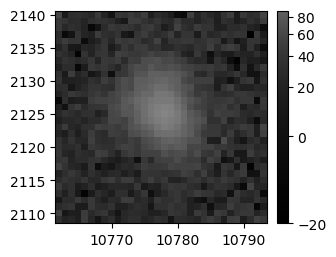

In [99]:
fig = plt.figure(figsize=(3, 3))
display = afw_display.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout.image)
plt.show()

Loop over all 'gri' bands and extract the cutout image in each one.

In [100]:
bands = ["g","r","i"]
cutout = {}

for band in bands:
    dataId = {'tract': tract, 'patch': patch, 'band': band}
    #deep_coadd = butler.get('deep_coadd', band=band,
    #                    tract=tract, patch=patch)
    cutout[band] = butler.get("deep_coadd", parameters=parameters,
                              dataId=dataId)
    #cutout[band] = deep_coadd.Factory(deep_coadd, bbox)

In [101]:
cutout

{'g': <lsst.afw.image._exposure.ExposureF at 0x7fd304af5330>,
 'r': <lsst.afw.image._exposure.ExposureF at 0x7fd3044f0270>,
 'i': <lsst.afw.image._exposure.ExposureF at 0x7fd34ad06d70>}

In [102]:
cutouts = [cutout[band] for band in bands]
multibandexposure = MultibandExposure.fromExposures(bands, cutouts)

In [103]:
type(multibandexposure)

lsst.afw.image._exposure._multiband.MultibandExposure

In [104]:


# Example RA and Dec coordinates
rahms = ra_cen_euclid * u.hourangle  # 12 hours, 30 minutes, 36 seconds
decdms = dec_cen_euclid * u.deg    # +12 degrees, 24 minutes, 0 seconds

# Create a SkyCoord object
coordinates = SkyCoord(ra=rahms, dec=decdms, frame='icrs')

# Format the coordinates into an IAU-style string
name = (f'EUCLID J{coordinates.ra.to_string(unit=u.hourangle, sep="", precision=1, pad=True)}'
                  f'{coordinates.dec.to_string(sep="", precision=0, alwayssign=True, pad=True)}') #

print(name)

EUCLID J113734.1-490342


gri


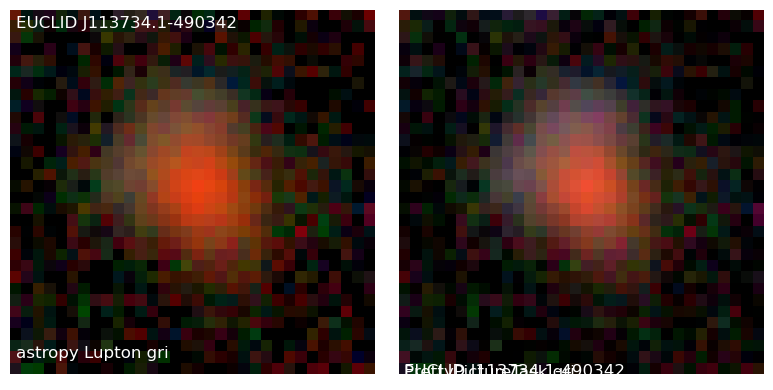

In [105]:
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(1,2,1)
showRGB(multibandexposure.image, bgr='gri', ax=ax, stretch=60, Q=10, name=name)

ax = fig.add_subplot(1,2,2)
prettyRGB(cutout, ax=ax, stretch=750, Q=0.7, name=name)

## 2. Cluster Abel 360


In [106]:
# Position of the BCG for A360, in degrees. 
ra_bcg = 37.865
dec_bcg = 6.98

# Looking for all patches in 2 * box_size_deg around it
box_size_deg = 0.1

Define the extent of the cutout in RA and Dec. Include the cos(dec) factor.

In [107]:
ra1 = ra_bcg + box_size_deg / np.cos(np.radians(dec_bcg))
ra2 = ra_bcg - box_size_deg / np.cos(np.radians(dec_bcg))
dec1 = dec_bcg - box_size_deg
dec2 = dec_bcg + box_size_deg
print('ra1 = %8.4f,  ra2 = %8.4f,  delta RA = %6.3f' %
      (ra1, ra2, np.abs(ra2-ra1)))
print('dec1 = %8.4f, dec2 = %8.4f, delta Dec = %6.3f' %
      (dec1, dec2, np.abs(dec2-dec1)))

ra1 =  37.9657,  ra2 =  37.7643,  delta RA =  0.201
dec1 =   6.8800, dec2 =   7.0800, delta Dec =  0.200


Define corners of the cutout.

The order is: SE, SW, NW, NE, as drawn in the plot below.

In [108]:
corners = np.asarray([[ra1, dec1], [ra2, dec1],
                      [ra2, dec2], [ra1, dec2]],
                     dtype='float')

## Identify all the tracts and patches of interest


In [109]:
center = geom.SpherePoint(ra_bcg, dec_bcg, geom.degrees)

radec = [geom.SpherePoint(ra2, dec1, geom.degrees),
         geom.SpherePoint(ra2, dec2, geom.degrees),
         geom.SpherePoint(ra1, dec1, geom.degrees),
         geom.SpherePoint(ra1, dec2, geom.degrees)]

tracts_and_patches = skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})
tp_dict

{10463: [61, 71, 62, 72]}

# Patch to use as anchor image

Define the tract and patch within which the central coordinates of the desired cutouts are most centered.

This will be the tract and patch referred to as the "anchor image" when creating the big cutout.

In [110]:
# This is the patch that contains the BCG
anchor_tract = 10463
anchor_patch = 61

Hold the tract and patch values for images that will contribute, in addition to the anchor image, to the final custom cutout in add_tracts_and_patches.

In [111]:
temp = []
for tract in tp_dict.keys():
     for patch in tp_dict[tract]:
        if (tract != anchor_tract) | (patch != anchor_patch):
            temp.append([tract, patch])
add_tracts_and_patches = np.asarray(temp, dtype='int')
#del temp

print('add these to the anchor patch: ')
print(add_tracts_and_patches)

add these to the anchor patch: 
[[10463    71]
 [10463    62]
 [10463    72]]


## Create the custom cutout, for the coadds in g, r and i.

This basically loops over the 3 bands (g,r,i), creating a large mosaic cutout of each coadd, using the code from the DP0.2 tutorial 03c_Big_deepCoadd_Cutout.ipynb. Typically takes ~1-2min to run for the 4 patches

In [118]:
filter_arr = ['g', 'r', 'i']
coadds = {'g':[], 'r': [], 'i': []}
for use_filter in filter_arr:
    anchor_dataId = {'tract': anchor_tract, 'patch': anchor_patch,
                 'band': use_filter}
    anchor_image = butler.get('deep_coadd', dataId=anchor_dataId)
    anchor_wcs = anchor_image.getWcs() 
    all_dataIds = [anchor_dataId]
    all_images = [anchor_image]
    all_tracts = [anchor_tract]
    
    for i in range(len(add_tracts_and_patches)):
        temp_tract = add_tracts_and_patches[i][0]
        temp_patch = add_tracts_and_patches[i][1]
        temp_dataId = {'tract': temp_tract, 'patch': temp_patch,
                       'band': use_filter}
        temp_image = butler.get('deep_coadd', dataId=temp_dataId)
    
        all_images.append(temp_image)
        all_dataIds.append(temp_dataId)
        all_tracts.append(temp_tract)
    
    del temp_tract, temp_patch, temp_dataId, temp_image

    getTemplateTask = GetTemplateTask()
    crval = geom.SpherePoint(ra_bcg, dec_bcg, geom.degrees)

    crpix = box_size_deg * 3600 / 0.2
    crpix1 = crpix
    crpix2 = crpix
    crpix = geom.Point2D(crpix1, crpix2)
    
    x = anchor_image.getWcs().getFitsMetadata()
    cdMatrix = [x['CD1_1'], x['CD1_2']], [x['CD2_1'], x['CD2_2']]
    
    projection = 'TAN'
    newWCS = makeSkyWcs(crpix, crval, cdMatrix, projection)
 
    corner_SE_deg = geom.SpherePoint(corners[0][0], corners[0][1], geom.degrees)
    corner_NW_deg = geom.SpherePoint(corners[2][0], corners[2][1], geom.degrees)
    corner_SE_pix = newWCS.skyToPixel(corner_SE_deg)
    corner_NW_pix = newWCS.skyToPixel(corner_NW_deg)
    
    xmin = int(np.floor(corner_SE_pix[0]))
    ymin = int(np.floor(corner_SE_pix[1]))
    xmax = int(np.floor(corner_NW_pix[0]))
    ymax = int(np.floor(corner_NW_pix[1]))
    
    newimg_shape = Image(geom.Box2I(minimum=geom.Point2I(x=xmin, y=ymin),
                                    maximum=geom.Point2I(x=xmax, y=ymax)),
                         dtype=np.float32)
    newimage_bbox = newimg_shape.getBBox()

    dI = all_dataIds[0]
    dataset_refs = list(butler.query_datasets('deep_coadd', data_id=dI))
    dataset_refs = set(dataset_refs)
    
    for dI in all_dataIds[1:]:
        dr = list(butler.query_datasets('deep_coadd', data_id=dI))
        dataset_refs = dataset_refs.union(set(dr))
    
    coadd_deferred_dataset_handle = [butler.getDeferred(dr) for dr in dataset_refs]
    sky_map = butler.get("skyMap")
    inputs = {"coaddExposures": coadd_deferred_dataset_handle,
              "bbox": newimage_bbox,
              "skyMap": sky_map,
              "wcs": newWCS, }
    print(f"{use_filter}-band: collecting the patches/tracts that overlap the desired bounding box")
    
    results = getTemplateTask.getExposures(coadd_deferred_dataset_handle,
                                           newimage_bbox, sky_map, newWCS)
    newimage = getTemplateTask.run(coaddExposures=results.coaddExposures, 
                                   bbox=newimage_bbox,
                                   wcs=newWCS, dataIds=results.dataIds,
                                   physical_filter=use_filter)
    #coadds.append(newimage.template)
    coadds[use_filter] = newimage.template

g-band: collecting the patches/tracts that overlap the desired bounding box


r-band: collecting the patches/tracts that overlap the desired bounding box


i-band: collecting the patches/tracts that overlap the desired bounding box


In [120]:
coadds_list = [coadds[band] for band in bands]
coadds_exp = MultibandExposure.fromExposures(bands, coadds_list)

gri


(-20.0, 3621.0)

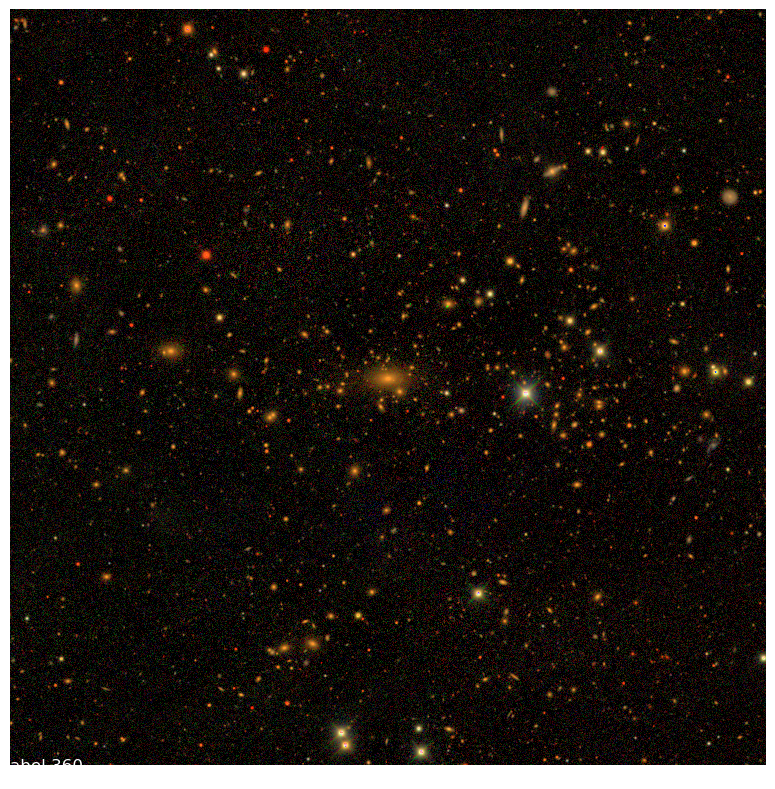

In [121]:
#fig, ax = plt.subplots(figsize=(8, 8), nrows=1, ncols=1, subplot_kw={'projection': WCS(coadds[0].getWcs().getFitsMetadata())})

rgb_original = showRGB(coadds_exp.image, bgr=['g', 'r', 'i'], stretch=60, Q=10, name='abel 360')#,stretch=0.01, Q=100, scale=[1, 1, 1])

rgb_extent = (newimage.template.getBBox().beginX, newimage.template.getBBox().endX,
              newimage.template.getBBox().beginY, newimage.template.getBBox().endY)


#ax.imshow(rgb_original, origin='lower', extent=rgb_extent)

ax.set_xlim([newimage.template.getBBox().beginX, newimage.template.getBBox().endX])
ax.set_ylim([newimage.template.getBBox().beginY, newimage.template.getBBox().endY])

(<matplotlib.patches.Circle at 0x7fd374c005f0>,)

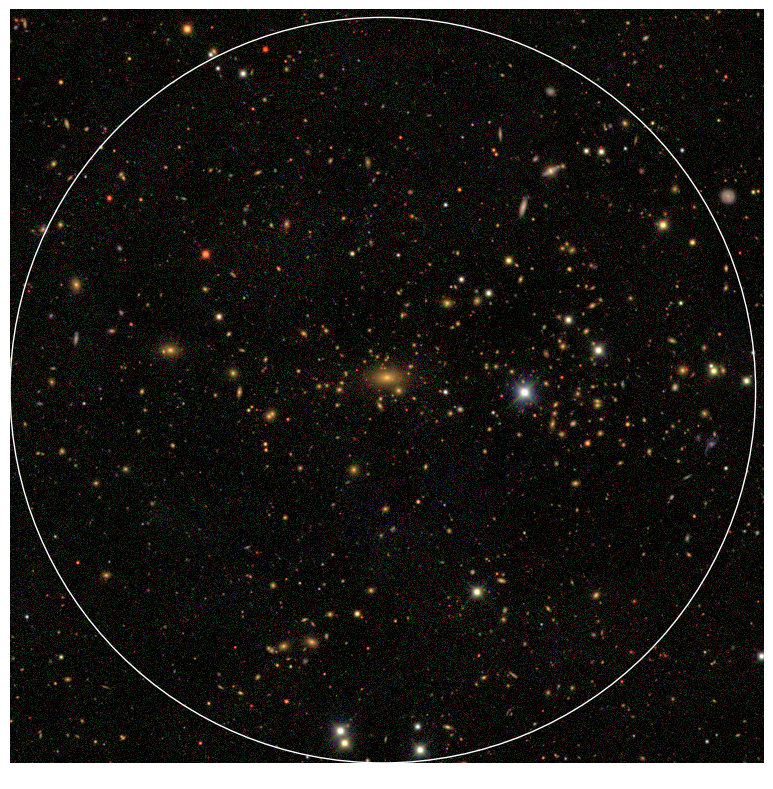

In [124]:
from photutils.aperture import SkyCircularAperture

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), subplot_kw={'projection':WCS(coadds['g'].getWcs().getFitsMetadata())})

#ax = fig.add_subplot(1,1,1)
prettyRGB(coadds, ax=ax, stretch=750, Q=0.7, name=fr"Abell 360 - {2*box_size_deg}$^\circ$ field")

coord = SkyCoord(ra=ra_bcg*u.degree, dec=dec_bcg*u.degree, frame='icrs')
aperture = SkyCircularAperture(coord, r=box_size_deg* u.deg)
pix_aperture = aperture.to_pixel(WCS(coadds['g'].getWcs().getFitsMetadata()))
pix_aperture.plot(color='w', lw=1)

# 3 Nate's script 

In [125]:
from lsst.pipe.tasks.prettyPictureMaker import PrettyPictureTask

ConfigClass = PrettyPictureTask.ConfigClass
ChannelRGBConfig = ConfigClass.channelConfig.itemType

prettyPicConfig = ConfigClass()

AttributeError: 'ConfigDictField' object has no attribute 'itemType'